In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt

## preparing the model

In [2]:
df = pd.read_csv('../week_3/data-week-3.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.applymap(
    lambda x: x.lower().replace(' ', '_') if (isinstance(x, str)) else x
)

In [4]:
df['totalcharges']= pd.to_numeric(
    df.totalcharges, errors='coerce'
).fillna(0)

In [5]:
df['churn'] = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=1)

In [7]:
## define test size to be the 20% of the full df, you can do it by
# 20%/80% = 1/4
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1
)

In [8]:
len(df_test), len(df_val), len(df_test)

(1409, 1409, 1409)

In [9]:
# avoid the random index
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [10]:
## get the rarget variable
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [11]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [12]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
    'gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 
    'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 
    'contract', 'paperlessbilling', 'paymentmethod'
]

In [13]:
dv = DictVectorizer(sparse=False)

dicts_train = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(dicts_train)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [14]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and dummy model

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [17]:
thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


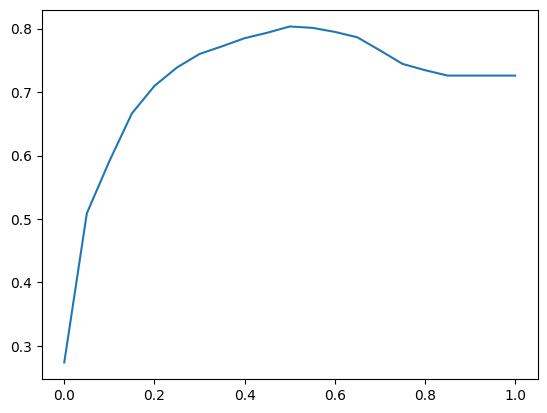

In [18]:
plt.plot(thresholds, scores)

In [19]:
from collections import Counter

In [20]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [21]:
Counter(y_val) ## we can see here the class imbalance 

Counter({0: 1023, 1: 386})

## Confusion matrix

In [22]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [23]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [24]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [25]:
tp, tn

(210, 922)

In [26]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [27]:
fp, fn

(101, 176)

In [28]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [29]:
# getting the perc
confusion_matrix / confusion_matrix.sum()

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

## precision and recall

In [30]:
(tp + tn) / (tp + tn + fp + fn) ## accuracy

0.8034066713981547

In [31]:
p = tp / (tp + fp)
p

0.6752411575562701

In [32]:
r = tp / (tp + fn)
r

0.5440414507772021

## ROC curves

#### intro

In [33]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [34]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [35]:
## evaluated by all possible thresholds
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [36]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [37]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

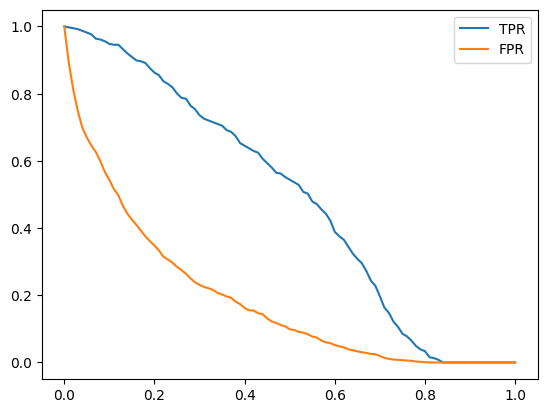

In [38]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.show()

#### random model

In [39]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))

In [40]:
((y_rand >= 0.5) == y_val).mean() ##this is the accuacy of the model

0.5017743080198722

In [41]:
## evaluated by all possible thresholds
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [42]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [43]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


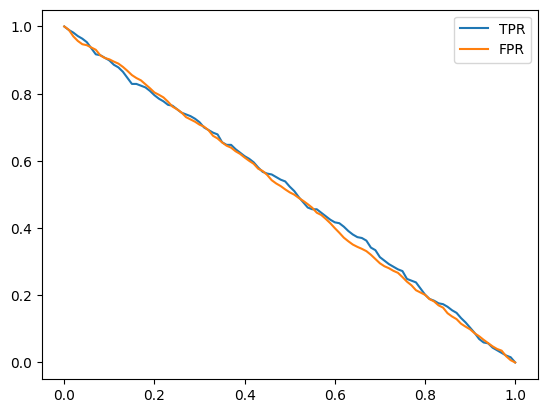

In [44]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
plt.show()

#### ideal model

In [45]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [46]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos]) ## orderes real values
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [47]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [48]:
## above this threshold ideally all are true (or 1)
((y_ideal_pred >= 0.726) == y_ideal).mean() 

1.0

In [49]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

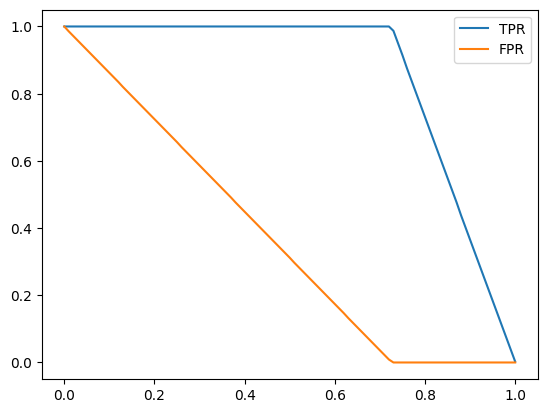

In [50]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()
plt.show()

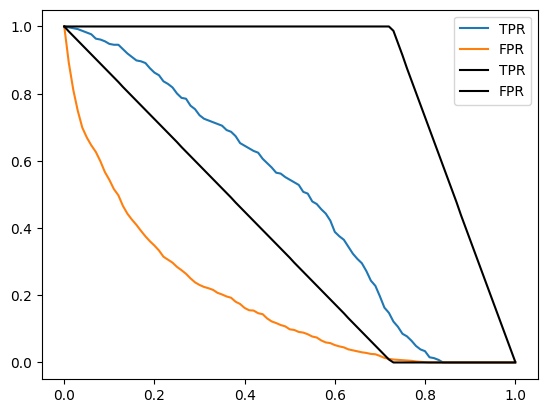

In [51]:
## plotting the ideal model over the real model we can see that the curve 
# of TPR is quite far from the ideal model, that is, we are making lot mistakes

plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')
plt.legend()
plt.show()

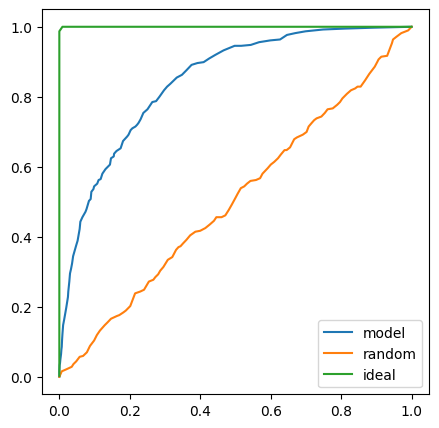

In [52]:
## plotting the FPR and TPR

plt.figure(figsize=(5, 5))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.legend()
plt.show()

#### using scikit learn

In [53]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

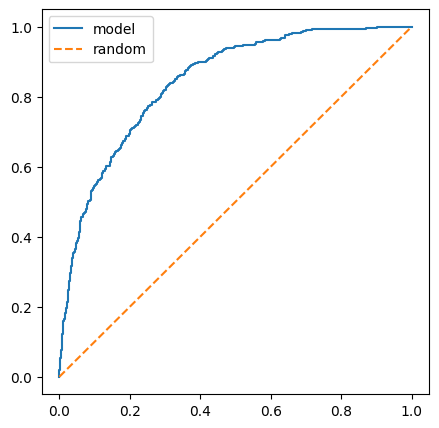

In [55]:
## plotting the FPR and TPR

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
plt.legend()
plt.show()

## ROC AUC

In [56]:
from sklearn.metrics import auc

In [57]:
auc(fpr, tpr)

0.8438530381535563

In [59]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [60]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [64]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438530381535563

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
roc_auc_score(y_val, y_pred)

0.8438530381535563

In [65]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [66]:
import random

In [78]:
n = 10000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8368

In [84]:
## the len(neg) - 1 is not used because is exclusive the high value
n = 50_000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n) 

In [85]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## cross-validation

In [103]:
def train(df, y_train, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [105]:
dv, model = train(df_train, y_train, C=0.001)

In [90]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [91]:
y_pred = predict(df_val, dv, model)

In [92]:
from sklearn.model_selection import KFold

In [97]:
from tqdm.auto import tqdm

In [112]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.4f +- %.4f' % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.8249 +- 0.0091
C=0.01 0.8399 +- 0.0090
C=0.1 0.8410 +- 0.0078
C=0.5 0.8401 +- 0.0064
C=1 0.8400 +- 0.0083
C=5 0.8410 +- 0.0079
C=10 0.8413 +- 0.0076


In [111]:
## training a final model

dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259